# MULTIPAC test bench example
This notebook showcases the basic utilisation of the library.

## Set up
First of all, load some useful libraries.

In [1]:
from pathlib import Path
import tomllib

Now we load a file that holds the position of every diagnostic as well as their nature: current probe, electric field probe, etc.

In [2]:
project = Path("../data")
config_path = Path(project, "example_configuration.toml")

with open(config_path, "rb") as f:
    config = tomllib.load(f)

We create a `MultipactorTest` object. It needs `config`, the test bench configuration, and a `.csv` file containing the data produced by `LabVIEW`.

In [3]:
from multipac_testbench.src.multipactor_test import MultipactorTest
results_path = Path(project, "120MHz-SWR4-run1.csv")  # send email placais@lpsc.in2p3.fr to get the file
multipactor_test = MultipactorTest(results_path, config)

## Exploring the data structure
The ``MultipactorTest`` object that we created has a ``pick_ups`` attribute, which is a ``list`` of ``PickUp`` objects.

In [4]:
print("The pick-ups are:")
for pick_up in multipactor_test.pick_ups:
    print(pick_up)

print(' ')
my_pick_up = multipactor_test.pick_ups[5]
print(f"The sixth pick-up is named {my_pick_up.name}.")

The pick-ups are:
 
The sixth pick-up is named E6.


Each ``PickUp`` has an attribute ``instruments``, holding its ``list`` of ``Instruments``.

In [5]:
instruments = my_pick_up.instruments
print("The instruments of this pick_up are:")
for instrument in instruments:
    print(instrument)
print(' ')

print(f"The first of those is a {instruments[0].class_name}, and it measured:\n{instruments[0].raw_data}.")

The instruments of this pick_up are:
 
The first of those is a CurrentProbe, and it measured:
Sample index
1      7.50
2      7.83
3      8.49
4      9.14
5      8.49
       ... 
694    7.50
695    8.81
696    9.47
697    8.16
698    8.16
Name: NI9205_MP6l, Length: 698, dtype: float64.


## The user interface
Hopefully, there is easier ways to access and plot the data.
We load the class of the instruments to plot.

In [6]:
from multipac_testbench.src.instruments.current_probe import CurrentProbe
from multipac_testbench.src.instruments.e_field_probe import ElectricFieldProbe
instruments_to_plot = (ElectricFieldProbe, CurrentProbe)

Now we can plot the raw signal measured by the current and electric field probes by using the ``plot_pick_ups`` method from ``MultipactorTest``.

(<Figure size 640x480 with 2 Axes>,
 {multipac_testbench.src.instruments.e_field_probe.ElectricFieldProbe: <Axes: ylabel='Voltage [V]'>,
  multipac_testbench.src.instruments.current_probe.CurrentProbe: <Axes: xlabel='Measurement index', ylabel='Multipactor current [$\\mu$A]'>})

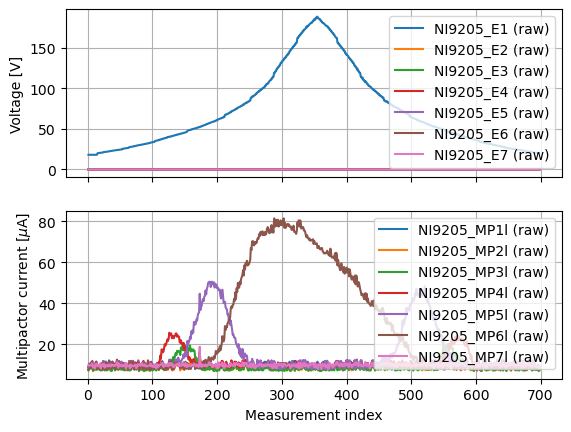

In [7]:
multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    raw=True,  # we did not define any post-treatment, so raw=False would plot the same data
)

In this test, we had issues with the electric field probe at the E1 pick-up.
The measured electric field was way too high, so we remove it from the plot by doing:

(<Figure size 640x480 with 2 Axes>,
 {multipac_testbench.src.instruments.e_field_probe.ElectricFieldProbe: <Axes: ylabel='Voltage [V]'>,
  multipac_testbench.src.instruments.current_probe.CurrentProbe: <Axes: xlabel='Measurement index', ylabel='Multipactor current [$\\mu$A]'>})

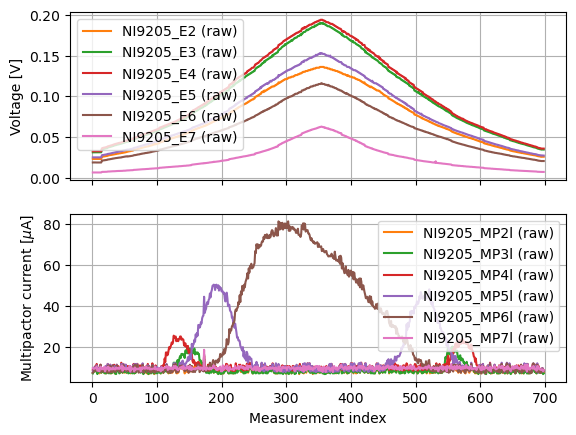

In [8]:
pick_up_to_exclude = ("E1", )

multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    pick_up_to_exclude=pick_up_to_exclude,
    raw=True
)

This is much better!
Now we would like to smooth the current data.

In [9]:
from multipac_testbench.src.util.post_treaters import running_mean
# you can replace running_mean by any function, it just needs to take in an array, and return another array with the same shape

from functools import partial
# partial allows us to set some function keywords arguments once and for all

current_smoother = partial(
    running_mean,  # the base function
    n_mean=10,     # to perform the running mean over 10 samples
    mode='same',   # for more info, go to the documentation
)

multipactor_test.add_post_treater(
    current_smoother,  # the smoothing function
    CurrentProbe,      # the instrument concerned by this post-treatment
)

Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.
Warning! Modifying the post treaters makes previously post-treated data obsolete.


The warnings are only here to say that the ``ydata`` attribute of every ``Instrument`` have been removed, and will be recomputed the first time access it.
Now we can plot the smoothed data:

(<Figure size 640x480 with 2 Axes>,
 {multipac_testbench.src.instruments.e_field_probe.ElectricFieldProbe: <Axes: ylabel='Voltage [V]'>,
  multipac_testbench.src.instruments.current_probe.CurrentProbe: <Axes: xlabel='Measurement index', ylabel='Multipactor current [$\\mu$A]'>})

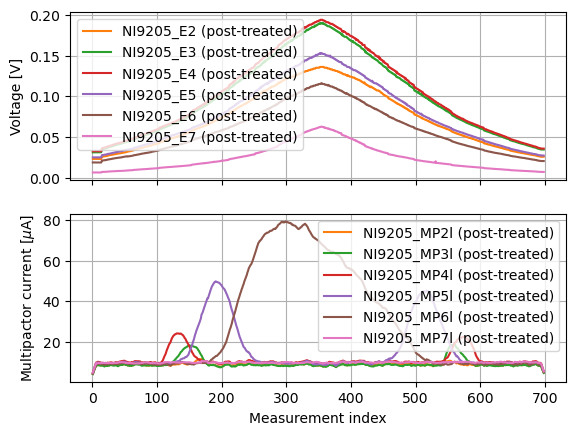

In [10]:
multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    pick_up_to_exclude=pick_up_to_exclude,
    raw=False,  # to plot the post-treated data
)

Note that you can define your own post-treater.
For example, if you want to plot the current in A instead of µA, define a function that multiplies an array by ``1e-6``.
Then, add it to the ``MultipactorTest`` with the ``add_post_treater`` method.

## Detecting multipator
We need to define a function that takes in the ``ydata`` of an ``Instrument``, and returns an boolean array where ``False`` means no multipactor, ``True`` means multipactor.

In [11]:
from multipac_testbench.src.util.multipactor_detectors import quantity_is_above_threshold
# this simple function returns True when ydata crosses a threshold

# Define our multipactor criterions, that we will apply on the CurrentProbe
current_multipactor_criterions = {
    'threshold': 14.,              # current above which there is multipactor
    'consecutive_criterion': 10,   # multipactor zones separated by this number of measure points or less will be gathered
    'minimum_number_of_points': 3, # multipactor zones measured on less than 3 consecutive points will not be considered as MP
}
current_multipac_detector = partial(quantity_is_above_threshold,
                                    **current_multipactor_criterions)

multipactor_test.set_multipac_detector(current_multipac_detector,  # function that detects multipactor
                                       CurrentProbe)               # Instrument on which it is applied

As every type of ``Instrument`` has different sensitivity, each one can have its own multipactor criterion. You can also call the ``Instrument.set_multipactor_detector`` or ``Instrument.add_post_treater`` methods to treat a specific ``Instrument`` differently.

(<Figure size 640x480 with 2 Axes>,
 {multipac_testbench.src.instruments.e_field_probe.ElectricFieldProbe: <Axes: ylabel='Voltage [V]'>,
  multipac_testbench.src.instruments.current_probe.CurrentProbe: <Axes: xlabel='Measurement index', ylabel='Multipactor current [$\\mu$A]'>})

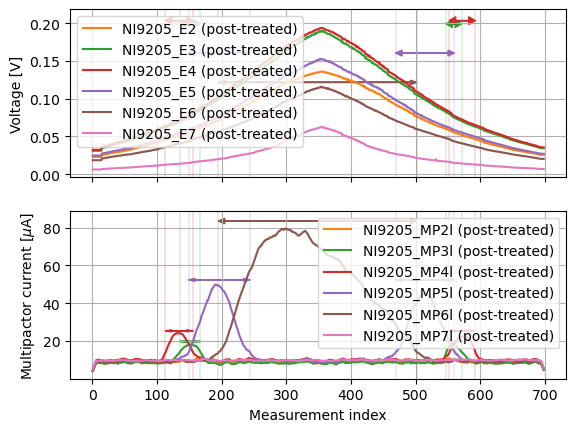

In [12]:
# We define that we want the multipactor zones calculated by the CurrentProbes on the ElectricFieldProbe and CurrentProbe plots.
multipactor_plots = {CurrentProbe: CurrentProbe,
                     ElectricFieldProbe: CurrentProbe,
                    }

# Also, we would like to save this plot, so we precise ``png_path``
png_path = results_path.with_suffix(".png")

multipactor_test.plot_pick_ups(
    instruments_to_plot=instruments_to_plot,
    pick_up_to_exclude=pick_up_to_exclude,
    png_path=png_path,
    multipactor_plots=multipactor_plots,
    raw=False,
)

## Creating animations
A sweet feature is the creation of animations, to reproduce what was measured by each instrument with time.

The animation will not appear in this notebook, you should go see it at ``gif_path``.

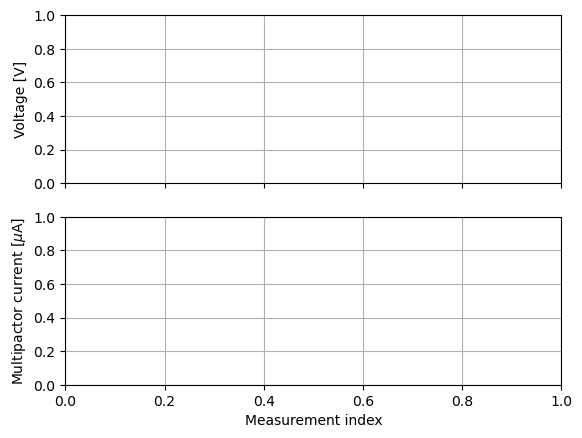

In [ ]:
gif_path = results_path.with_suffix(".gif")

multipactor_test.animate_pick_ups(
    (ElectricFieldProbe, CurrentProbe),                 # the instruments to plot
    pick_ups_to_ignore_for_limits=pick_up_to_exclude,   # E1 will be plotted without modifying the limits
    gif_path=gif_path,                                  # providing this will create a .gif file 
    fps=100,                                            # frames per second
    keep_one_frame_over=50,                             # to keep only one image over 50
)